**GUID:** 2507608

**GitHub URL:** (https://github.com/lordofanywhere/ai-for-the-arts-a/)[https://github.com/lordofanywhere/ai-for-the-arts-a/]

# Generating Text with Neural Networks

This notebook will showcase a generative AI model which can learn how to write in the style of William Shakespeare.

In this notebook, I am following the Machine Learning Project Checklist provided by Aurélien Géron in the Appendix B of _Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: concepts, tools, and techniques to build intelligent systems_.¹ The notebook sections follow this checklist, which has been slightly adapted for this educational project.


# 1. Framing the problem and looking at the big picture

Before deciding on a model to follow, it is important that we understand the problem and define it. In the case of commercial solutions, we can do so in business terms.

For the model we will build, a way of framing the problem could be asking ourselves the following question: "How would Shakespeare reply to any text-based prompt?"

We should consider how the solution will be intended to be used, if there are any current workarounds to achieve what our solution intends to achieve, and if there are other solutions that could achieve better results.

For this model, we have chosen to use Character Recurrent Neural Networks (char-RNN).

Play the following video to understand how Neural Networks work:

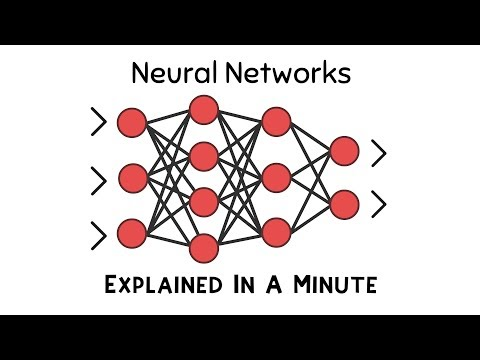

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('rEDzUT3ymw4', width=800, height=450)

Neural networks are powerful architectures that can be used for many different generative and self-learning tasks. Char-RNN can be used to predict the next character in a sentence and generate new text, character by character, based on the training data.² For this reason, char-RNN seems like a suitable model to answer our question.

# 2. Getting the Data

To build a model, we need to identify a dataset that we can use to train and test the model. As we are working with plays by William Shakespeare, a suitable dataset would be a text document with many (or all, if possible) of the plays he wrote. For this exercise, Aurélien Géron has curated a dataset that we will use.

In the following cell, we will import the dataset to our model. The dataset will be imported from [https://homl.info/shakespeare](https://homl.info/shakespeare), but we strongly discourage looking at the full dataset at this stage in order to prevent unconscious bias to creep into our model.

We use the open source library TensorFlow, created by the Google Brain team and released in 2015. This library simplifies the process of acquiring training data, training the model, presenting results and refining the model.³

TensorFlow will store the data locally as the variable `shakespeare_text`.

In [2]:
import tensorflow as tf

shakespeare_url = "https://homl.info/shakespeare"  # shortcut URL
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

2023-12-10 19:28:49.372004: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


When running the code displayed above, TensorFlow will show a red warning. This is not an error message and it does not require any user action. TenshorFlow is simply letting us know that it will take advantage of our GPU in order to speed up the process.⁴

# 3. Exploring the Data to gain insights

Below, we can explore our dataset.

Try changing the value `1000` for any other number and run the code. You will be able to see all the characters in the dataset up to the character point you have set. By default, the code shows 1000 characters.

In [3]:
print(shakespeare_text[:1000]) # not relevant to machine learning but relevant to exploring the data

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# 4. Preparing the Data

It is recommended that we work on copies on the data, so that we do not modify the original dataset and can revert to it at any point. In this case, the dataset is hosted in a third party web storage, and we can import it again if we need to.

We will preprocess the text data using `tf.keras.layers.TextVectorization`, which is a preprocessing layer that converts text strings into an integer-based representation that can be read by an `Embedding` layer or `Dense` layer.⁵

We're splitting the input text on each unicode character, and we are standardising it so that it uses lowercase throughout.

The `TextVectorization` layers are non-trainable. We must set their state before training the model. We are doing so by "adapting them", or exposing the preprocessing layer to traing data. We use the `adapt()` method for this.

In [4]:
text_vec_layer = tf.keras.layers.TextVectorization(split="character",
                                                   standardize="lower")
text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0]

Running the code below will show you the characters of the dataset represented numerically. The dataset now looks completely different and it is no longer human-readable.

In [5]:
print(text_vec_layer([shakespeare_text]))

tf.Tensor([[21  7 10 ... 22 28 12]], shape=(1, 1115394), dtype=int64)


We will now drop the tokens `0`, which are assign to padding, and `1`, assigned to unknown characters. We will not use these.

We will calculate the number of distinct characters and the total number of characters in the dataset.

In [6]:
encoded -= 2  # drop tokens 0 (pad) and 1 (unknown), which we will not use
n_tokens = text_vec_layer.vocabulary_size() - 2  # number of distinct chars = 39
dataset_size = len(encoded)  # total number of chars = 1,115,394

We can use the `print()` function to see the number of distinct characters and the total number of characters:

In [7]:
print(n_tokens, dataset_size)

39 1115394


We will now define the function `to_dataset`. It will convert the encoded text sequences into a dataset that we can use to train our model. `to_dataset` segments the text and organises it into batches of a overlapping sequences.⁶

Here, we could shuffle the dataset to enhance randomness during training, but we have not done so in the code below.

In [8]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

We will now create the training, validation and test datasets.

As our dataset has a total of `1115394` characters, we will divide it as such:

- Training dataset (`train_set`): 1,000,000 characters
- Validation dataset (`valid_set`): 60,000 characters
- Test dataset (`test_set`): up to 60,000 characters

The test dataset will be short of 60,000 characters, as our dataset does not have 1,120,000 characters, but this should not be a problem.

We will randomise the training set (note the `shuffle=True` in the code). This should allow the neural network to learn from a more representative sample from each batch, which should result in better performance and generalisation.

It is generally good practice to shuffle the dataset before training,⁷ and it helps to reduce order bias, promote generalisation, prevent overfitting, stabilise learning, improve regularisation, and adapting to new examples while maintaining a balanced distribution of old and new data.⁸

In [9]:
length = 100
tf.random.set_seed(42)
train_set = to_dataset(encoded[:1_000_000], length=length, shuffle=True,
                       seed=42)
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)

# 5. Exploring different models and choose the best one

When exploring a problem, it is recommended to train many different models with small samples of training data and measure and compare their performance. This will help us choose the model that best performs for the goal we are set to achieve, as well as the type of errors the models make.

We will skip this step in our example, but it is good practice for more complex problems where different models could be used.

# 6. Fine-tuning: Building, Training and Testing the Model

We will now train our neural network model in 10 epochs or dataset batches. Training AI models is compute-intensive and time-consuming.⁹ Our Shakespeare model is simple, but it will take some time and computational power to train it nonetheless.

Be patient when the code below: you can go and make yourself a cup of tea, but make sure that your computer does not go to sleep or the process may be interrupted.

In [10]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_shakespeare_model", monitor="val_accuracy", save_best_only=True)
history = model.fit(train_set, validation_data=valid_set, epochs=10,
                    callbacks=[model_ckpt])

Epoch 1/10
  31247/Unknown - 852s 27ms/step - loss: 1.3938 - accuracy: 0.5738INFO:tensorflow:Assets written to: my_shakespeare_model/assets


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 875s 28ms/step - loss: 1.3938 - accuracy: 0.5738 - val_loss: 1.6123 - val_accuracy: 0.5314
Epoch 2/10
31247/31247 [==============================] - ETA: 0s - loss: 1.2954 - accuracy: 0.5969INFO:tensorflow:Assets written to: my_shakespeare_model/assets


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 856s 27ms/step - loss: 1.2954 - accuracy: 0.5969 - val_loss: 1.5911 - val_accuracy: 0.5374
Epoch 3/10
31246/31247 [============================>.] - ETA: 0s - loss: 1.2785 - accuracy: 0.6004INFO:tensorflow:Assets written to: my_shakespeare_model/assets


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 858s 27ms/step - loss: 1.2785 - accuracy: 0.6004 - val_loss: 1.5712 - val_accuracy: 0.5433
Epoch 4/10
31245/31247 [============================>.] - ETA: 0s - loss: 1.2680 - accuracy: 0.6025INFO:tensorflow:Assets written to: my_shakespeare_model/assets


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 837s 27ms/step - loss: 1.2680 - accuracy: 0.6025 - val_loss: 1.5676 - val_accuracy: 0.5443
Epoch 5/10
31247/31247 [==============================] - ETA: 0s - loss: 1.2614 - accuracy: 0.6041INFO:tensorflow:Assets written to: my_shakespeare_model/assets


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 841s 27ms/step - loss: 1.2614 - accuracy: 0.6041 - val_loss: 1.5623 - val_accuracy: 0.5453
Epoch 6/10
31246/31247 [============================>.] - ETA: 0s - loss: 1.2570 - accuracy: 0.6049INFO:tensorflow:Assets written to: my_shakespeare_model/assets


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 837s 27ms/step - loss: 1.2569 - accuracy: 0.6049 - val_loss: 1.5670 - val_accuracy: 0.5467
Epoch 7/10
31247/31247 [==============================] - ETA: 0s - loss: 1.2536 - accuracy: 0.6055INFO:tensorflow:Assets written to: my_shakespeare_model/assets


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 842s 27ms/step - loss: 1.2536 - accuracy: 0.6055 - val_loss: 1.5590 - val_accuracy: 0.5470
Epoch 8/10
31247/31247 [==============================] - 834s 26ms/step - loss: 1.2503 - accuracy: 0.6063 - val_loss: 1.5595 - val_accuracy: 0.5460
Epoch 9/10
31247/31247 [==============================] - ETA: 0s - loss: 1.2483 - accuracy: 0.6068INFO:tensorflow:Assets written to: my_shakespeare_model/assets


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 839s 27ms/step - loss: 1.2483 - accuracy: 0.6068 - val_loss: 1.5564 - val_accuracy: 0.5504
Epoch 10/10
31247/31247 [==============================] - 837s 27ms/step - loss: 1.2461 - accuracy: 0.6073 - val_loss: 1.5680 - val_accuracy: 0.5478


We have trained our model! 

We will now create a Keras Sequential model, which is a model that we cna use for preprocessing. It adds additional layers where each layer has exactly one input tensor and one output tensor.¹⁰ 

One of the layers of our Keras Sequential model is a Lambda layer, which allows us to use arbitrary expresions as a `Layer` when building Sequential and Functional API models. `Lambda` layers are used for experimentation or simple operations,¹¹ like the simple neural network model we have built.

In [11]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    model
])

We can now use the model to predict the next character in a sentence.

Note that the code computes the probability of the next character in the string (sentence) provided in the input (in this case, `To be or not to b`) and predicts ("chooses") the most probable character. 

To do all of these computations, the model uses the encoded dataset, so it will need to refer back to our vectorised text layer (`text_vec_layer`).

In [12]:
y_proba = shakespeare_model.predict(["To be or not to b"])[0, -1]
y_pred = tf.argmax(y_proba)  # choose the most probable character ID
text_vec_layer.get_vocabulary()[y_pred + 2]

1/1 [==============================] - 1s 520ms/step


'e'

We will now ensure that our model generates a variety of outputs, instead of generating the same words over and over. We will do this by sampling the next character randomly, with a probability equal to the estimated probability.

The `categorical()` function will sample random class indices, given the class log probabilities (logits).¹²

In [13]:
log_probas = tf.math.log([[0.5, 0.4, 0.1]])  # probas = 50%, 40%, and 10%
tf.random.set_seed(42)
tf.random.categorical(log_probas, num_samples=8)  # draw 8 samples

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 1, 0, 2, 1, 0, 0, 1]])>

We will now define the function `next_char`, introducing a `temperature` number by which we can divide the logits.

We can tweak the `temperature` number in our model. A temperature close to zero will favour high-probability characters, while higher temperatures will result in more random outputs.¹²

We will play with the temperature further below to see the different results.

In [14]:
def next_char(text, temperature=1):
    y_proba = shakespeare_model.predict([text])[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

The following function, `extend_text`, will call `next_char` to generate the next character and add it to our input text.¹²

We can change hte `n_chars` value from `50` to whatever number of characters we want for our output. If you do so, remember to run the code again.

In [18]:
def extend_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

We will add the following code to ensure reproducibility every time the code is run:

In [19]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

We have successfully created a simple neural network model! We will see how it works in the following section.

# 7. Presenting the solution: Generating Text

Now that we have created our model, we can finally use it.

We have provided three different quotes from Shakespeare:

- “To be, or not to be“ – _Hamlet_ (Act III, Scene I).
- “The lady doth protest too much“ – _Hamlet_ (Act III, Scene I).
- “Uneasy is the head that wears a crown“– _Henry IV, Part 2_ (Act III, Scene I).

However, you can replace these with any text. It doesn't even need to be Shakespeare quotes! Using all kinds of texts may yield some funny results.

You can also tinker with the temperatures. The examples below have set the temperature to `0.01`, `1` and `100` respectively. Change them to any number you wish.

Remember that a temperature close to 0 will return high-probability characters, so the higher the temperature, the more random the output will be.

In [20]:
print(extend_text("To be, or not to be", temperature=0.01))

1/1 [==============================] - 0s 24ms/step
To be, or not to be a man of the strong strange
and the strong for th


In [21]:
print(extend_text("The lady doth protest too much", temperature=1))

1/1 [==============================] - 0s 23ms/step
The lady doth protest too much
giffors will but go, and hereof and reason within


In [22]:
print(extend_text("Uneasy is the head that wears a crown", temperature=100))

1/1 [==============================] - 0s 24ms/step
Uneasy is the head that wears a crowng ,mt'&o3g:ady-$
wh!nse?pws&ert--vgerdjw?c-y-ewznj


Do you recognise Shakespeare in all of these outputs?

# 8. Launch, monitor and maintain the system

Once our solution is ready for production and we have tested that it answers our questions or solves our problems, it is time to release it to a wider audience. We could present this solution on a dedicated website, or upload our Jupyter notebook to Kaggle, Google Colaboratory, or GitHub. We can make a nice presentation or UX explaining why our solution achieves our objectives, as well as explaining what worked, what did not, our assumptions, and the limitations o out solution.

We would usually write monitoring code to check the live performance of our model regularly and receive alerts when the performance drops.

We will skip this last step for this model, but it is very important in models that are critical for internal or external workflows. Think about ChatGPT – if the model were to degrade over time and no one paid attention to its performance, it would generate unexpected results eventually, impacting the quality of its answers and user trust.

# 9. Critical Reflection

This model is a great example of a simple, yet effective that anyone with little experience with neural networks can follow and achieve impressive results in just a few hours.

When evaluating the model, it will become apparent that it will often generate meaningless, albeit grammatically correct, results. When adjusting the character count in the `extend_text` function to `100`, setting the `temperature` to `1`, and using the prompt `The lady doth protest too much`, I got the following text in one occasion:

    The lady doth protest too much
    and discontent the heart soon not, as name.
    
    rutland:
    he sat him make else;
    come, but obeir'd hope 

These lines look like taken from Shakespeare's plays but, except for "the lady doth protest too much", the lines have been generated by the model. On closer inspection, it is difficult to find meaning on them. This contrasts with the results generated by large language models (LLMs) such as ChatGPT or HuggingChat, which in many times could pass as human-generated.

Adjusting the temperature of the model will generate disparate results. For example, adjusting the character count in the `extend_text` function to `100`, setting the `temperature` to `0.01` and using the prompt `To be, or not to be` will **always** generate the following output, regardless of the amount of times we run the code:

    To be, or not to be a word:
    i will not say 'tis not so i will be a word:
    i will not say 'tis not so i will be a word:
    i
    
When setting the temperature to `1`, the results will be different every time we run the code. That is also the case when we set the temperature to `100`, although the randomness of the characters will be very visible.

When testing the model using a temperature of `100`, and the prompt `To be, or not to be` (with a character count of 100), I got the following output in one occasion:

    Uneasy is the head that wears a crown&vm:o'ns3li$,zou!3iigarrbia
n?p-!o;yffstu:u fescbhrhpmflkpn'ojhgeuwt?o!r.r?is3f
rgabtfd$nperuvdov.t

To get an output that answers our question _"How would Shakespeare reply to any text-based prompt?"_ we need to find the adequate temperature: too low a number, and the model will always answer with the same words, reminding us of Jack Torrance in _The Shining_, rather than William Shakespeare; too high a number, however, will generate gibberish.

This specific model, as it has been trained using quotes from Shakespeare, will likely suffer from the same biases than the source material. Moreover, if the dataset includes variants and emendations, the model may replicate some of the bias introduced by scholars that have made those changes.¹³ To understand if the model reproduces these biases, we could explore the source dataset and compare with critical interpretations or annotations of the plays covered.

As all of Shakespeare's works are in the public domain, this model does not breach any author's intellectual property when using Shakespeare's data. This would not apply to any annotations or derivative works that may be subjected to copyright. It is important that we ensure that we utilise data that we have permission to utilise, and whenever necessary, that we appropriately attribute ownership.

This is a simple model that can be adapted to different solutions and data types. For example, it could be used to explore a language's history, including the grammar and vocabulary on any given time. We could digitise (using OCR technologies, for example) and prepare data from different sources from a distinctive period in time, similarly to the way in which we prepared the Shakespeare data. We can then use this vectorised data to train the model, and allow the model to learn how a language was written during said period. This method could be useful to understand the evolution of a language's grammar and spelling, and it could be a fun tool for philological studies.

Naturally, if we use the model for different purposes, there will be different ethical concerns that we will need to take into consideration. The source of the data must be carefully selected, understanding any historical bias and procuring that we don't introduce any bias (selection or otherwise) or that we use any private or sensitive data that could cause harm in individuals, groups or the society as a whole. We should take every precaution to ensure that we do not perpetuate bias, oppresion or harm. 

There is no one-size-fits-all solution and every purpose will come with its unique set of challenges that we will need to carefully address.

# Bibliography

1. **Géron, Aurélien**, _Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems_, 7th Release.Second edition; updated for Tensor Flow2 (Beijing Boston Farnham Sebastopol Tokyo: O’Reilly, 2020)
2. **Bons, Vincent**, ‘Building a Text Generation Model from Scratch’, _Wingedsheep: Artificial Intelligence Blog_, 2022 <https://wingedsheep.com/building-a-language-model/> [accessed 9 December 2023]; **Géron, Aurélien**, ‘Natural Language Processing with RNNs and Attention’, in _Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems_, Third edition (Beijing Boston Farnham Sebastopol Tokyo: O’Reilly, 2023), pp. 577–634
3. **Yegulalp, Serdar**, ‘What Is TensorFlow? The Machine Learning Library Explained’, _InfoWorld_, 2022 <https://www.infoworld.com/article/3278008/what-is-tensorflow-the-machine-learning-library-explained.html> [accessed 9 December 2023]
4. **mCoding**, ‘Answer to “What Does This Tensorflow Message Mean? Any Side Effect? Was the Installation Successful?”’, _Stack Overflow_, 2020 <https://stackoverflow.com/a/65333085> [accessed 9 December 2023]
5. ‘Tf.Keras.Layers.TextVectorization  |  TensorFlow v2.14.0’, _TensorFlow v2.14.0_, 2023 <https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization> [accessed 10 December 2023]; ‘Working with Preprocessing Layers | TensorFlow Core’, _TensorFlow_, 2023 <https://www.tensorflow.org/guide/keras/preprocessing_layers> [accessed 10 December 2023]
6. **Tirendaz AI**, ‘Text Generation with TensorFlow’, _Kaggle_, 2023 <https://kaggle.com/code/tirendazacademy/text-generation-with-tensorflow> [accessed 10 December 2023]
7. **Chawla, Avi**, ‘Why Is It Important To Shuffle Your Dataset Before Training An ML Model’, _Daily Dose of Data Science_, 2023 <https://www.blog.dailydoseofds.com/p/why-is-it-important-to-shuffle-your> [accessed 10 December 2023]
8. **Kabaar, Sofien**, ‘Answer to “What Is the Purpose of Shuffling the Training Data before Feeding It into a Neural Network?”’, _Quora_, 2023 <https://www.quora.com/What-is-the-purpose-of-shuffling-the-training-data-before-feeding-it-into-a-neural-network> [accessed 10 December 2023]
9. **Scale Team, Barrett Williams, and Marwan Mattar**, ‘Training and Building Machine Learning Models: The Foundational Guide’, _Scale_, 2022 <https://scale.com/customers/model-training-building> [accessed 9 December 2023]
10. ‘The Sequential Model | TensorFlow Core’, _TensorFlow_, 2023 <https://www.tensorflow.org/guide/keras/sequential_model> [accessed 10 December 2023]
11. **Keras Team**, ‘Keras Documentation: Lambda Layer’, _Keras_ <https://keras.io/api/layers/core_layers/lambda/> [accessed 10 December 2023]
12. **Géron, Aurélien**, ‘Natural Language Processing with RNNs and Attention’, in _Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems_, Third edition (Beijing Boston Farnham Sebastopol Tokyo: O’Reilly, 2023), pp. 577–634
13. **Gatta, Carla Della**, ‘Confronting Bias and Identifying Facts: Teaching Resistance Through Shakespeare’, in _Teaching Social Justice Through Shakespeare: Why Renaissance Literature Matters Now_, ed. by Hillary Eklund and Wendy Beth Hyman, 2019, p. 167.



